In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import  mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.filterwarnings('ignore')

In [3]:
weather = pd.read_csv("Weather.csv")
revenue = pd.read_csv("Revenue.csv")

## Data Cleaning

In [4]:
print(weather.shape)
weather.head()

(86990, 10)


,time,temperature,dew_point,humidity,wind,wind_speed,pressure,precipitation,condition,dt
0,0:20:00,0,0,100%,S,11,982,0,Mist,20180101
1,0:50:00,0,0,100%,S,14,983,0,Mist,20180101
2,1:20:00,0,0,100%,S,11,982,0,Mist,20180101
3,1:50:00,0,0,100%,S,14,982,0,Mostly Cloudy,20180101
4,2:20:00,0,0,100%,S,14,981,0,Light Rain,20180101


In [6]:
#for humidity colum, remove the % and convert to int
weather["humidity"] = weather["humidity"].str.replace("%","")
weather['humidity'] = weather['humidity'].astype(str).astype(int)

In [7]:
weather = weather.groupby("dt")[['temperature', 'dew_point', 'humidity', 'wind_speed', 'pressure', 'precipitation']].mean().reset_index()

In [8]:
print(weather.shape)
weather.head()

(1754, 7)


,dt,temperature,dew_point,humidity,wind_speed,pressure,precipitation
0,20180101,3.240741,3.018519,98.444444,20.555556,979.111111,0.0
1,20180102,2.333333,2.175439,98.035088,13.543860,985.035088,0.0
2,20180103,1.923077,1.653846,97.307692,15.461538,979.807692,0.0
3,20180104,2.285714,1.428571,92.857143,24.040816,973.959184,0.0
4,20180105,2.290909,1.618182,91.581818,23.563636,975.309091,0.0


In [53]:
print(revenue.shape)
revenue.head()

(1749, 2)


,Date,Revenue
0,20180101,0
1,20180102,0
2,20180103,3087465
3,20180104,2770763
4,20180105,0


In [54]:
#change the Date name in weather to be same as revenue for merging
weather.rename(columns = {'dt':'Date'}, inplace = True)

In [56]:
#merge both dataset
data = weather.merge(revenue, left_on='Date', right_on='Date', how='outer')
print(data.shape)
data.head()

(1762, 8)


,Date,temperature,dew_point,humidity,wind_speed,pressure,precipitation,Revenue
0,20180101,3.240741,3.018519,98.444444,20.555556,979.111111,0.0,0.0
1,20180102,2.333333,2.175439,98.035088,13.543860,985.035088,0.0,0.0
2,20180103,1.923077,1.653846,97.307692,15.461538,979.807692,0.0,3087465.0
3,20180104,2.285714,1.428571,92.857143,24.040816,973.959184,0.0,2770763.0
4,20180105,2.290909,1.618182,91.581818,23.563636,975.309091,0.0,0.0


Let's take a look at the missing values

In [57]:
data.isnull().sum()

Date              0
temperature       8
dew_point         8
humidity          8
wind_speed        8
pressure          8
precipitation     8
Revenue          13
dtype: int64

In [58]:
missing_revenue = data.loc[data.Revenue.isnull()]
missing_revenue

,Date,temperature,dew_point,humidity,wind_speed,pressure,precipitation,Revenue
90,20180401,2.181818,1.854545,96.690909,16.963636,974.036364,0.0,NaN
357,20181225,-4.262295,-5.180328,93.573770,12.098361,993.245902,0.0,NaN
364,20190101,-0.050847,-0.305085,98.220339,27.661017,982.711864,0.0,NaN
474,20190421,6.981818,3.981818,81.709091,9.800000,998.854545,0.0,NaN
722,20191225,3.679245,2.735849,95.641509,11.924528,984.018868,0.0,NaN
729,20200101,0.942308,-0.980769,86.692308,18.076923,997.269231,0.0,NaN
831,20200412,6.208333,-7.145833,38.062500,18.270833,996.750000,0.0,NaN
1088,20201225,0.666667,-0.104167,94.270833,15.333333,979.750000,0.0,NaN
1095,20210101,-0.625000,-0.708333,99.416667,13.645833,985.875000,0.0,NaN
1184,20210404,2.270833,-3.250000,66.875000,12.375000,991.687500,0.0,NaN


In [59]:
missing_revenue.groupby('Date').count()

,temperature,dew_point,humidity,wind_speed,pressure,precipitation,Revenue
Date,,,,,,,
20180401,1,1,1,1,1,1,0
20181225,1,1,1,1,1,1,0
20190101,1,1,1,1,1,1,0
20190421,1,1,1,1,1,1,0
20191225,1,1,1,1,1,1,0
20200101,1,1,1,1,1,1,0
20200412,1,1,1,1,1,1,0
20201225,1,1,1,1,1,1,0
20210101,1,1,1,1,1,1,0


In [60]:
revenue[revenue.Revenue == 0]

,Date,Revenue
0,20180101,0
1,20180102,0
4,20180105,0
1747,20221027,0
1748,20221028,0


There are about 13 days that does not have any info about the revenue that was made that day, looking closely those days are Christmas day, New year day and Easter day. We will therefore fill them with zero as 2018 New year has the revenue as zero

In [61]:
 data['Revenue'] = data['Revenue'].fillna(0)

We can drop the remaining 8 missing rows with no weather info 

In [62]:
data = data.dropna()

In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1754 entries, 0 to 1753
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           1754 non-null   int64  
 1   temperature    1754 non-null   float64
 2   dew_point      1754 non-null   float64
 3   humidity       1754 non-null   float64
 4   wind_speed     1754 non-null   float64
 5   pressure       1754 non-null   float64
 6   precipitation  1754 non-null   float64
 7   Revenue        1754 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 123.3 KB


modify some of the columns to the correct datatype it should have

In [64]:
#convert Date column to datetime
data['Date'] = pd.to_datetime(data['Date'], format='%Y%m%d')

In [68]:
#remove the duplicates
data.duplicated().sum()

0

In [70]:
data.describe()

,temperature,dew_point,humidity,wind_speed,pressure,precipitation,Revenue
count,1754.000000,1754.000000,1754.000000,1754.000000,1754.000000,1754.0,1.754000e+03
mean,7.987806,3.778157,77.714509,13.502493,992.121874,0.0,6.358445e+08
std,8.620843,7.564584,15.007379,5.606174,8.749408,0.0,2.640471e+10
min,-19.541667,-21.604167,29.108696,0.333333,956.171875,0.0,0.000000e+00
25%,1.189732,-1.223958,67.424375,9.222292,987.008475,0.0,3.249969e+06
50%,7.833333,3.354167,80.276926,12.691964,993.031250,0.0,5.026275e+06
75%,15.135417,9.869792,90.175984,17.229167,997.656250,0.0,7.166325e+06
max,26.791667,19.777778,100.000000,33.062500,1021.812500,0.0,1.105855e+12


From the describe method above we can see that there is an outlier in Revenue feature

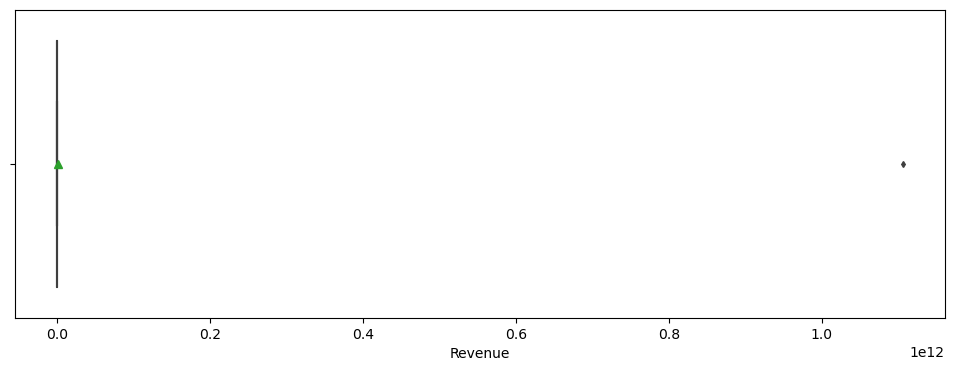

In [71]:
#Box Plot
fig, ax = plt.subplots(figsize=(12,4))
sns.boxplot(x = 'Revenue', data = data, orient = 'h', width = 0.8, fliersize = 3, showmeans=True, ax = ax)
plt.show()

The box plot above confirms this, so let's remove the outlier

In [72]:
mean = data['Revenue'].mean()
sd = data['Revenue'].std() 
data = data[(data['Revenue'] <= mean+(3*sd))]

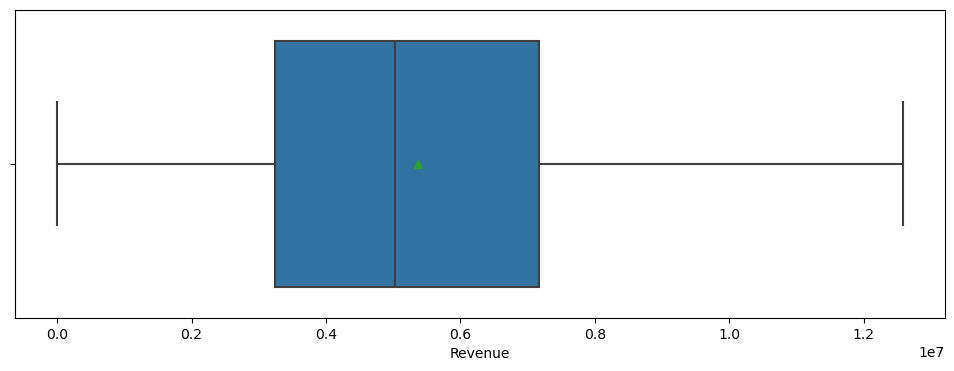

In [73]:
#Box Plot
fig, ax = plt.subplots(figsize=(12,4))
sns.boxplot(x = 'Revenue', data = data, orient = 'h', width = 0.8, fliersize = 3, showmeans=True, ax = ax)
plt.show()

 ## Data Processing

In [75]:
def create_features(data):
    """
    Create time series features based on data.
    """
    data['dayofweek'] = data.Date.dt.dayofweek
    data['month'] = data.Date.dt.month
    data['quarter'] = data.Date.dt.quarter
    data['year'] = data.Date.dt.year
    data['dayofyear'] = data.Date.dt.dayofyear
    return data

data = create_features(data)

In [79]:
#standardizing the data

data[['temperature', 'dew_point', 'humidity', 'wind_speed', 'pressure', 'precipitation', 'dayofyear', 'dayofweek', 'quarter', 'month', 'year']] = StandardScaler().fit_transform(data[['temperature', 'dew_point', 'humidity', 'wind_speed', 'pressure', 'precipitation', 'dayofyear', 'dayofweek', 'quarter', 'month', 'year']])


## Data Visualization

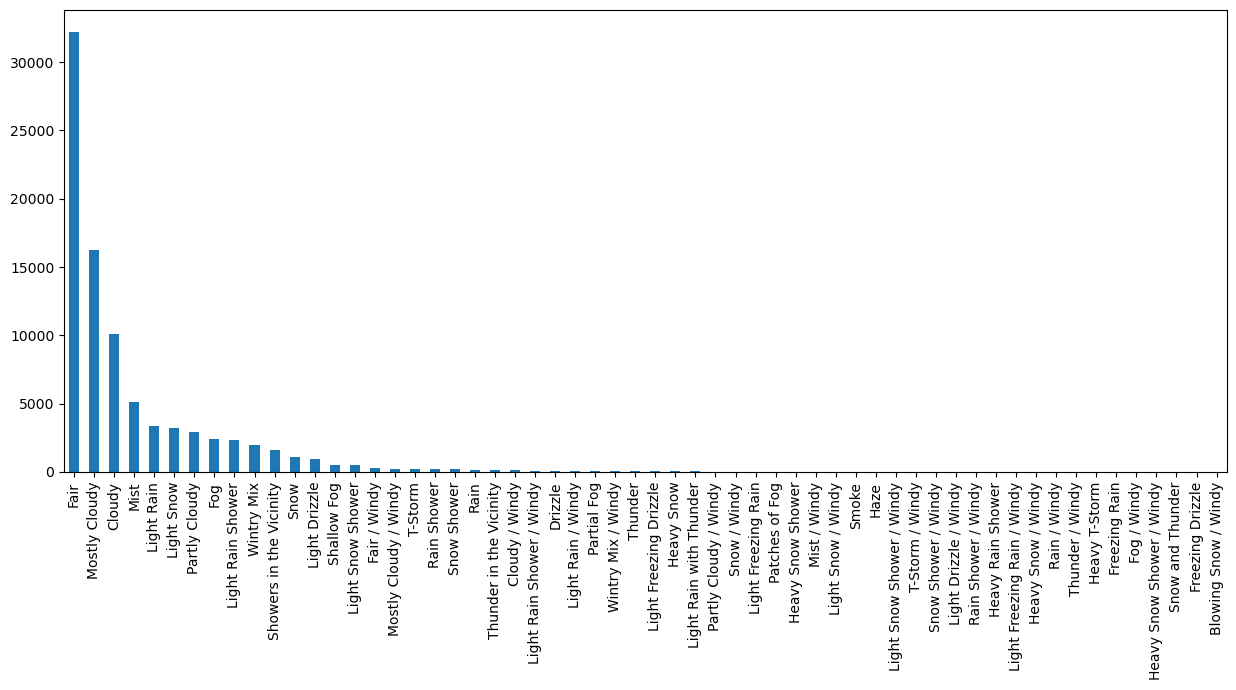

In [34]:
cond = dict(data['condition'].value_counts())
series = pd.Series(cond.values(), index=cond.keys(), name="Weather Condition")
series.plot.bar(figsize=(15, 6))
plt.show()

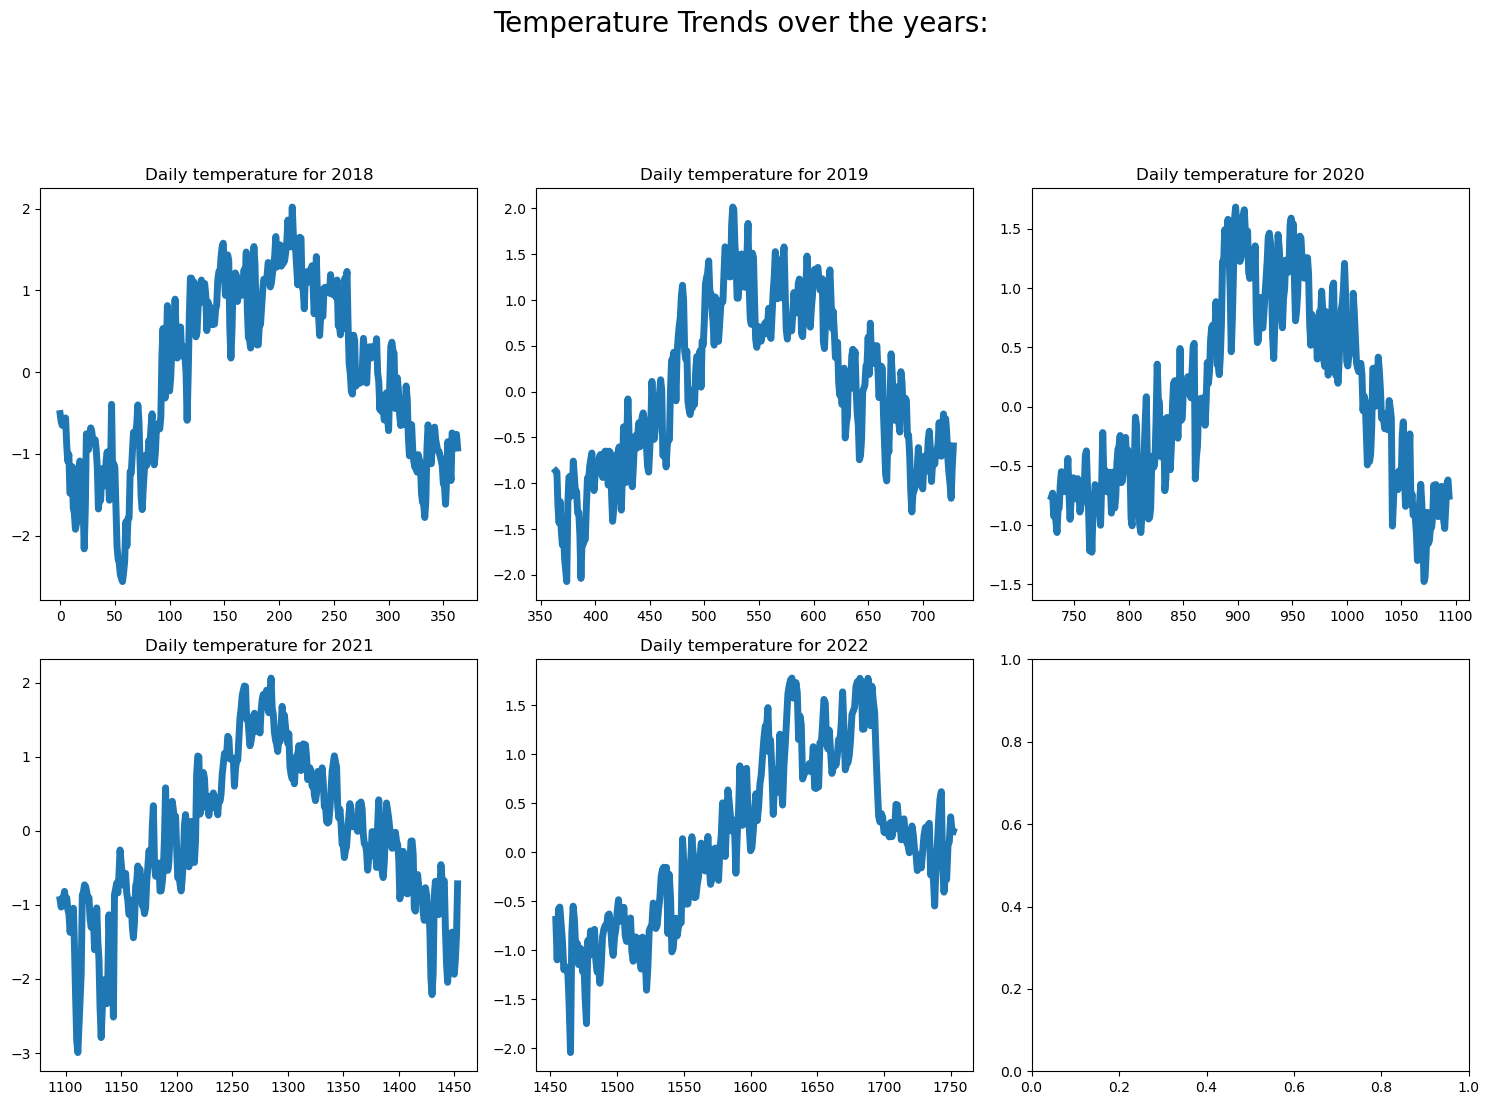

In [35]:
#Let's look at how the daily temperature changed over the years.

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()
ax_idx = 0
year = [2018, 2019, 2020,2021, 2022]
for i in year:
    a = data.groupby('Date', as_index=False, sort=False)['temperature'].mean()
    a[a.Date.dt.year == i].temperature.plot(kind='line',
                  title=f'Daily temperature for {i}',
                  lw=5,
                  ax=axs[ax_idx])
    ax_idx += 1
fig.suptitle(f'Temperature Trends over the years: ',
                 size=20,
                 y=1.1)
plt.tight_layout()
plt.show()

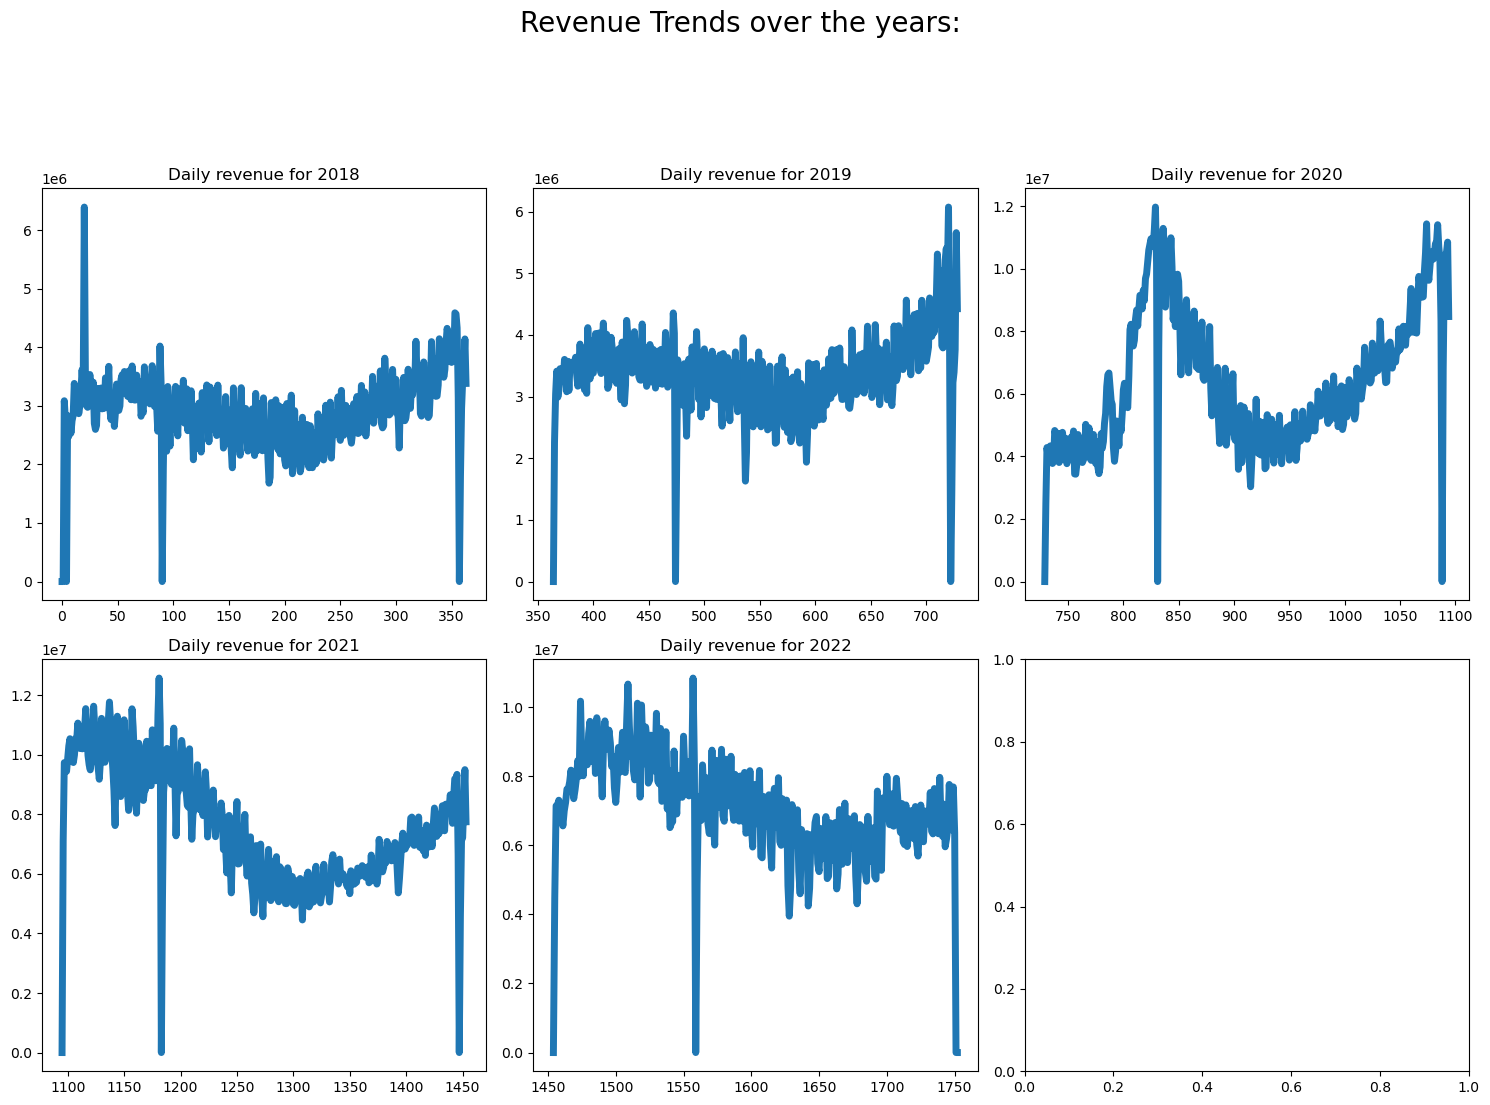

In [36]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()
ax_idx = 0
year = [2018, 2019, 2020,2021, 2022]
for i in year:
    a = data.groupby('Date', as_index=False, sort=False)['Revenue'].mean()
    a[a.Date.dt.year == i].Revenue.plot(kind='line',
                  title=f'Daily revenue for {i}',
                  lw=5,
                  ax=axs[ax_idx])
    ax_idx += 1
fig.suptitle(f'Revenue Trends over the years: ',
                 size=20,
                 y=1.1)
plt.tight_layout()
plt.show()

Let's check for a correlation between various measurements, such as temperature, pressure and wind speed

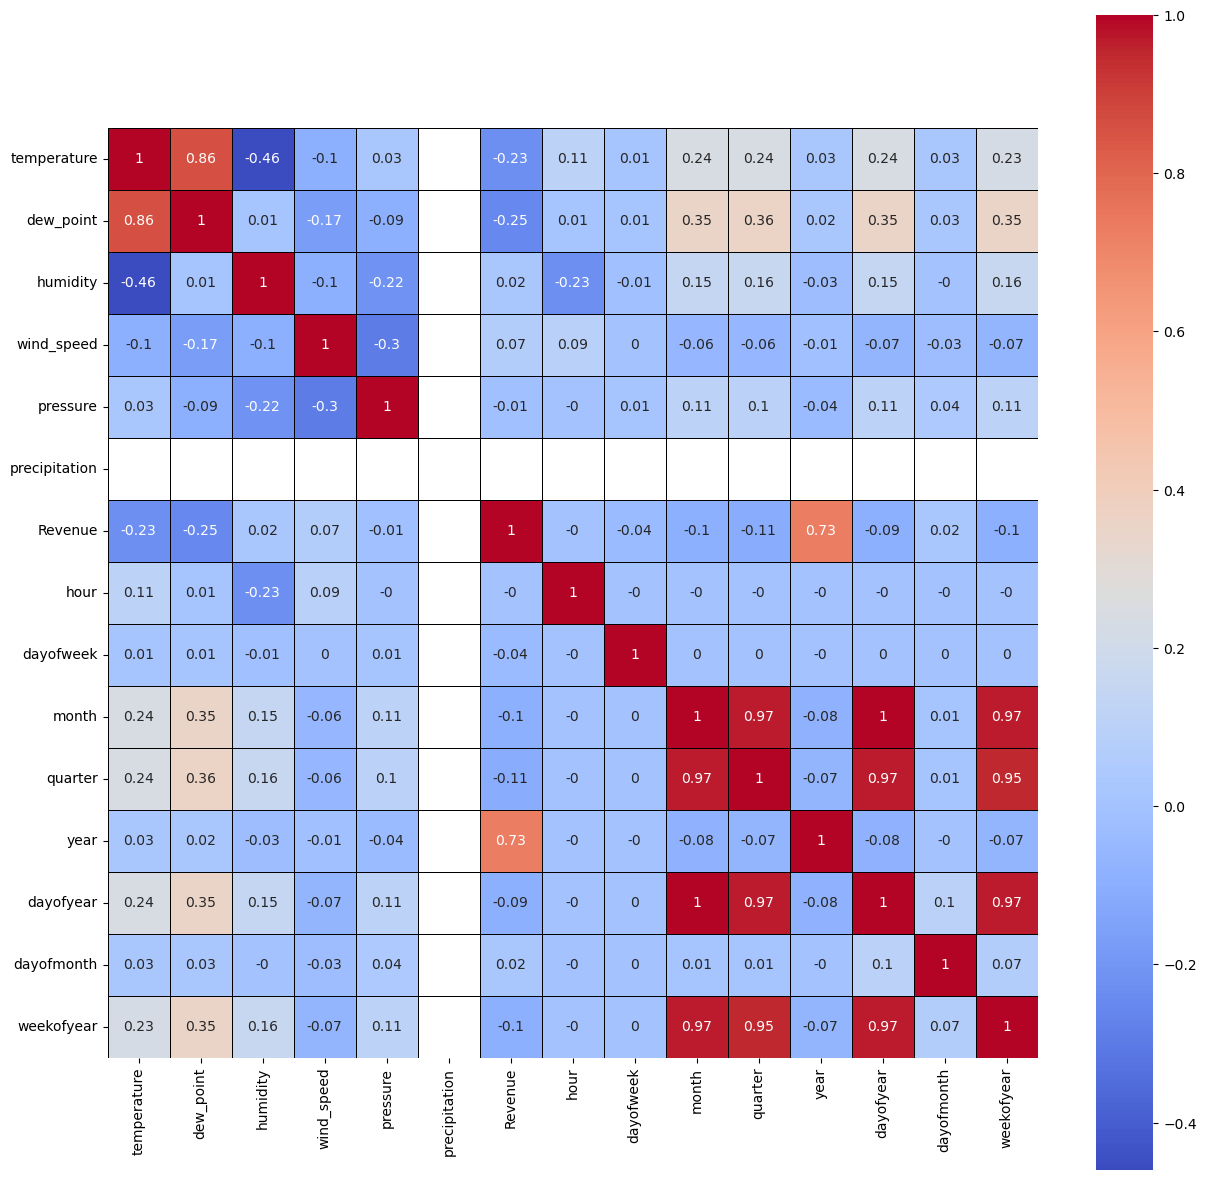

In [37]:
chef_corr = data.corr().round(2)

fig, ax = plt.subplots(figsize=(15,15))

sns.heatmap(chef_corr,
            cmap = 'coolwarm',
            square = True,
            annot = True,
            linecolor = 'black',
            linewidths = 0.5)
plt.show()

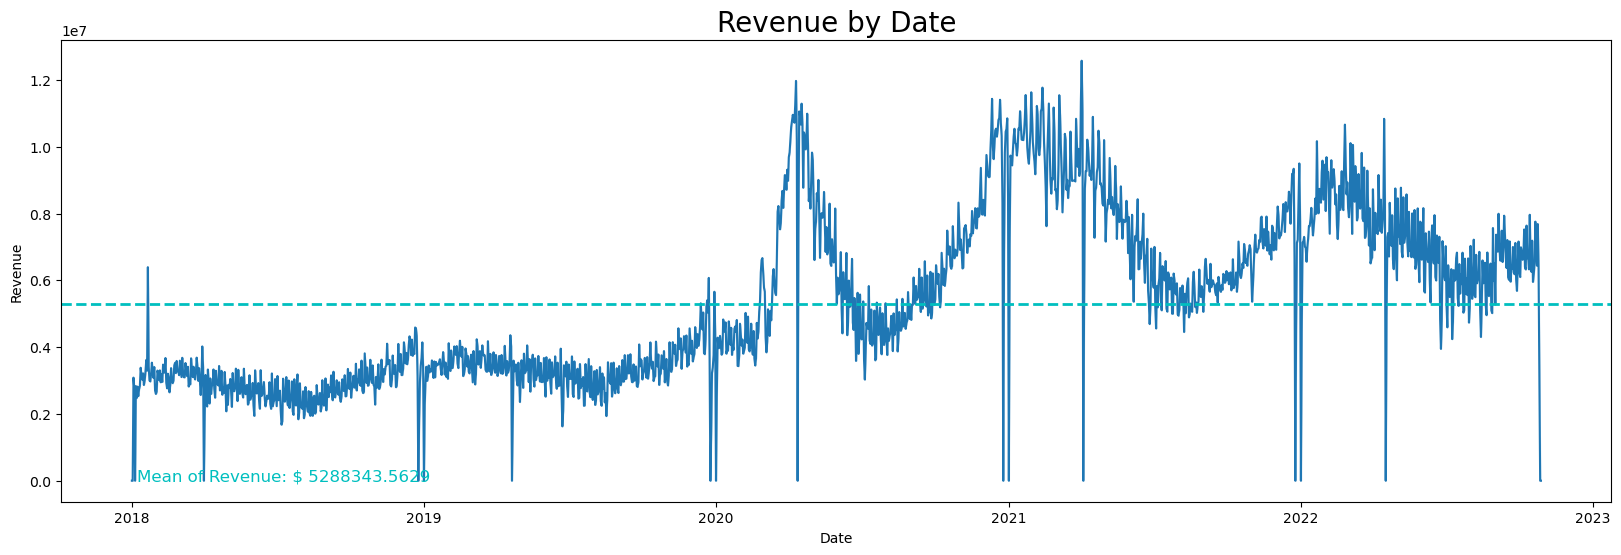

In [38]:
plt.figure(figsize=(20, 6))
sns.lineplot(data=data, x='Date', y='Revenue')
plt.axhline(data.Revenue.mean(), color='c', linestyle='--', linewidth=2)
plt.annotate('Mean of Revenue: $ {}'.format(round(data.Revenue.mean(),4)), 
             (data.Date[350], 30), 
             fontsize=12, 
             color='c')
plt.title('Revenue by Date', fontsize=20)
plt.ylabel('Revenue')
plt.show()

<Figure size 2000x600 with 0 Axes>

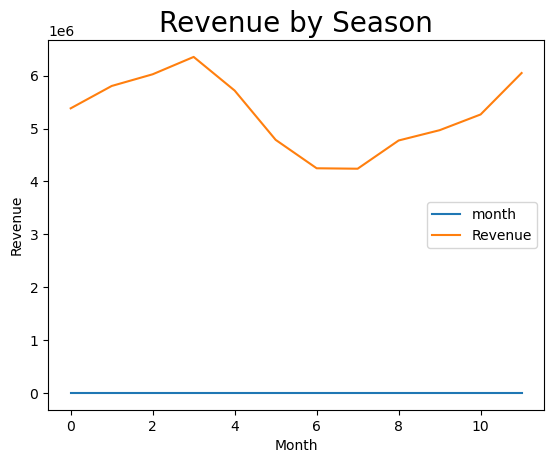

In [39]:
plt.figure(figsize=(20, 6))
a = data.groupby('month', as_index=False)['Revenue'].mean().plot()
plt.title('Revenue by Season', fontsize=20)
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.show()

This proves the research that **good** weather has a strong negative effect on demand (i.e., fewer revenue with good weather, probably because people has other things to do like swimming, or going out) and vice verser

<Figure size 2000x600 with 0 Axes>

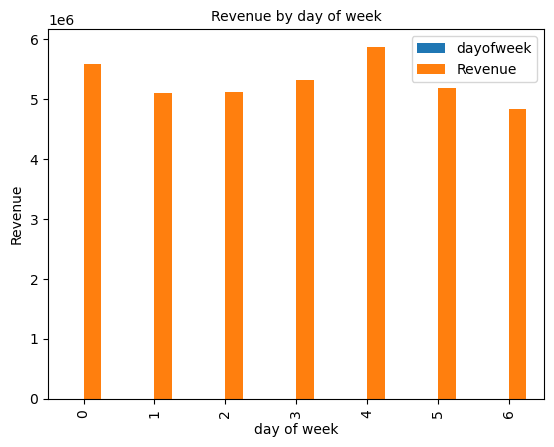

In [40]:
plt.figure(figsize=(20, 6))
a = data.groupby('dayofweek', as_index=False)['Revenue'].mean().plot(kind='bar')
plt.title('Revenue by day of week', fontsize=10)
plt.xlabel('day of week')
plt.ylabel('Revenue')
plt.show()

The findings also suggest that the weather effect is more pronounced on weekends compared to work-days and from above we can see that more revenue come during the weekdays conmpared to weekends

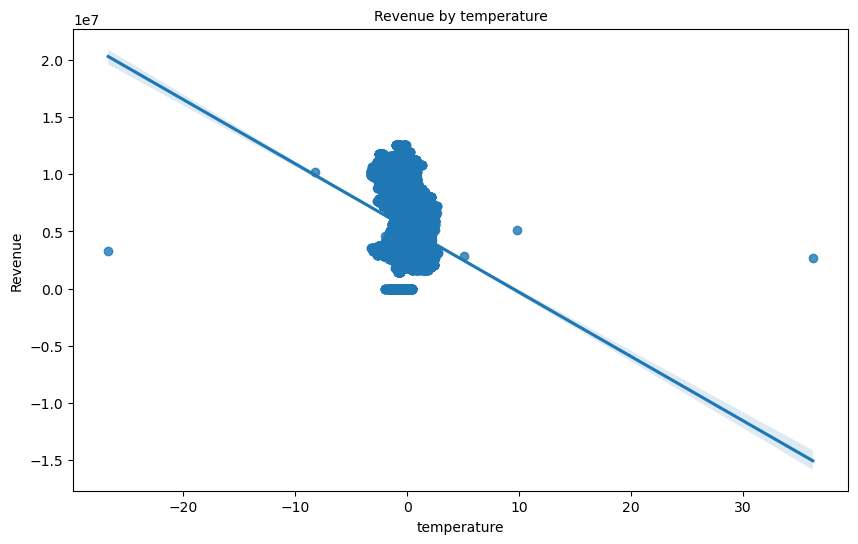

In [41]:
plt.figure(figsize=(10,6))
sns.regplot(data=data, x='temperature', y='Revenue')
plt.title('Revenue by temperature', fontsize=10)
plt.show()

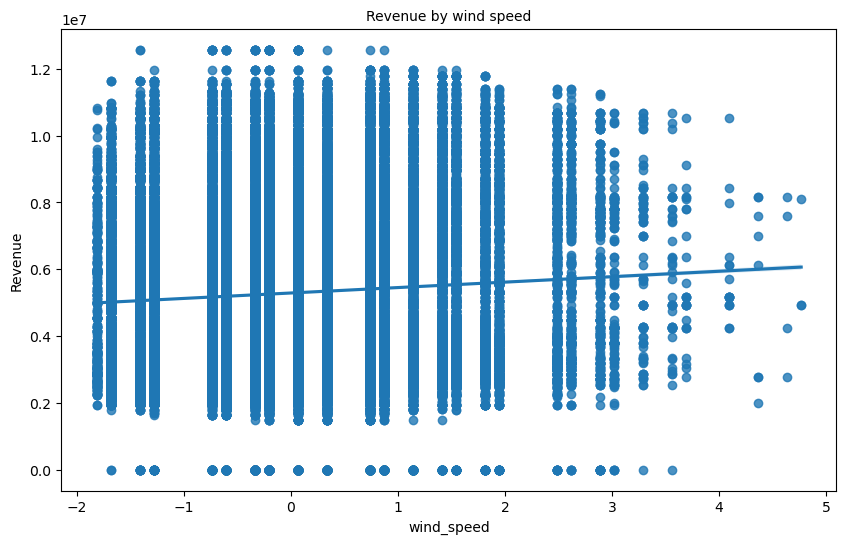

In [42]:
plt.figure(figsize=(10,6))
sns.regplot(data=data, x='wind_speed', y='Revenue')
plt.title('Revenue by wind speed', fontsize=10)
plt.show()

## Modeling and Evaluation

In [80]:
# adding lag features

def add_lags(df):
    target_map = df['Revenue'].to_dict()
    df['lag1'] = (df.Date - pd.Timedelta('30 days')).map(target_map)
    df['lag2'] = (df.Date - pd.Timedelta('60 days')).map(target_map)
    df['lag3'] = (df.Date - pd.Timedelta('90 days')).map(target_map)
    return df

In [81]:
data = add_lags(data)

In [82]:
# train model Using Cross Validation

tss = TimeSeriesSplit(n_splits=5, test_size=30*1, gap=1)
data = data.sort_values('Date')

In [83]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(data):
    train = data.iloc[train_idx]
    test = data.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['temperature', 'dew_point', 'humidity', 'wind_speed', 'pressure', 'precipitation', 'dayofyear', 'dayofweek', 'quarter', 'month', 'year', 'lag1','lag2','lag3']
    TARGET = 'Revenue'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:5811702.43822	validation_1-rmse:6554813.25303
[100]	validation_0-rmse:2448026.32863	validation_1-rmse:2752656.02966
[200]	validation_0-rmse:1351025.37220	validation_1-rmse:1340486.51430
[300]	validation_0-rmse:1036716.72906	validation_1-rmse:954198.20096
[400]	validation_0-rmse:945490.06078	validation_1-rmse:863154.11179
[500]	validation_0-rmse:883146.21268	validation_1-rmse:808426.27739
[600]	validation_0-rmse:839257.31795	validation_1-rmse:788152.24521
[646]	validation_0-rmse:817244.31442	validation_1-rmse:795692.90517
[0]	validation_0-rmse:5827350.01808	validation_1-rmse:5855175.57347
[100]	validation_0-rmse:2452228.11812	validation_1-rmse:2326754.69881
[200]	validation_0-rmse:1353540.66721	validation_1-rmse:1122626.24759
[300]	validation_0-rmse:1035828.06526	validation_1-rmse:753869.72077
[400]	validation_0-rmse:946571.92840	validation_1-rmse:669701.96178
[500]	validation_0-rmse:885515.02788	validation_1-rmse:616219.11814
[600]	validation_0-rmse:844413.13627	v

In [84]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 888919.7151
Fold scores:[785413.6818366749, 555141.1911264256, 611459.4556443079, 726816.1298313637, 1765768.11685545]


## Predicting the Future

In [85]:
# Retrain on all data
data = create_features(data)

FEATURES = ['temperature', 'dew_point', 'humidity', 'wind_speed', 'pressure', 'precipitation', 'dayofyear', 'dayofweek', 'quarter', 'month', 'year', 'lag1','lag2','lag3']
TARGET = 'Revenue'

X_all = data[FEATURES]
y_all = data[TARGET]

reg = XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:5855150.89768
[100]	validation_0-rmse:2457904.71749
[200]	validation_0-rmse:1360601.84105
[300]	validation_0-rmse:1049693.60970
[400]	validation_0-rmse:962753.56920
[499]	validation_0-rmse:906386.01052


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [86]:
# Create future dataframe
from dateutil.relativedelta import relativedelta, MO
future= pd.date_range(data.Date.max()+relativedelta(days=1),
                      data.Date.max()+relativedelta(months=1), 
                      freq='1d')
future_df = pd.DataFrame(future, columns=['Date'])
future_df['isFuture'] = True
data['isFuture'] = False
data_and_future = pd.concat([data, future_df])
data_and_future = create_features(data_and_future)
data_and_future = add_lags(data_and_future)

In [87]:
future_w_features = data_and_future.query('isFuture').copy()

In [88]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])
future_w_features['pred']

0     7555427.5
1     5340390.0
2     7610223.5
3     7553675.0
4     7553675.0
5     7553675.0
6     7848171.5
7     7601387.5
8     5382717.0
9     7656183.5
10    7599635.0
11    7599635.0
12    7599635.0
13    7848171.5
14    7601387.5
15    5382717.0
16    7656183.5
17    7599635.0
18    7656310.0
19    7686685.5
20    7935222.0
21    7688438.0
22    5469767.5
23    7743234.0
24    7686685.5
25    7686685.5
26    7686685.5
27    7935222.0
28    7688438.0
29    5469767.5
30    7743234.0
Name: pred, dtype: float32

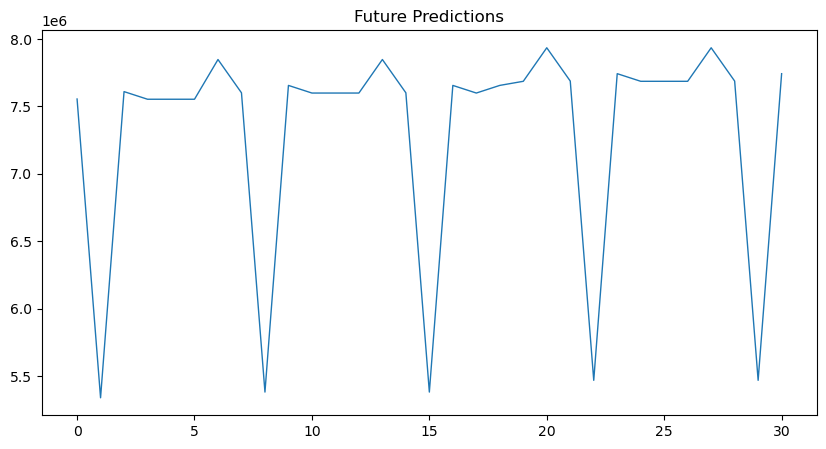

In [89]:
future_w_features['pred'].plot(figsize=(10, 5),
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()